In [1]:
import neighbors
from neighbors import make_tables, dist, connect_stats, plot
%reload_ext autoreload
%autoreload 2

In [2]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
from scipy.optimize import minimize
import warnings
from tqdm import tqdm

In [3]:
client = CAVEclient(global_only=True)
client = CAVEclient('minnie65_phase3_v1')

In [4]:
presyn_df = ['allen_v1_column_types_slanted']
df = client.materialize.query_table(presyn_df[0],split_positions=True)
df.loc[df['cell_type'] == '6CT', 'cell_type'] = '6P'
df.loc[df['cell_type'] == '6IT', 'cell_type'] = '6P'

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
L1 = [290,400]
L23 = [400,589]
L4 = [589,736]
L5 = [736,896]
L6 = [896,1061]
WM = [1061,1156]
depths = np.array([L1,L23,L4,L5,L6,WM])
depth_names = np.array(['23','23','4','5','6','6'])

In [6]:
df = make_tables.rename_by_layer(df,depths,depth_names)

In [7]:
pre_root_ids = [864691135428608048]
pree = []
for i in range(len(pre_root_ids)):
    pre_grab = df.query(f"pt_root_id == @pre_root_ids[{i}]")
    pree.append(pre_grab)

In [8]:
np.unique(df.cell_type)

array(['23P', '23_BC', '23_BPC', '23_MC', '4P', '4_BC', '4_BPC', '4_MC',
       '5P_IT', '5P_NP', '5P_PT', '5_BC', '5_BPC', '5_MC', '5_P', '6_BC',
       '6_MC', '6_P', 'NGC', 'Omitted_P', 'Unsure'], dtype=object)

In [9]:
cell_types = ['23_BC','23_MC','23_BPC','4_BC','4_MC','4_BPC','5_BC','5_MC','5_BPC']
#,'6_BC','6_BPC','6_MC']
pre_df,pre = [],[]
for i in range(len(cell_types)):
    pre_grab = df.query(f"cell_type == @cell_types[{i}]")
    pre_df.append(pre_grab)
for i in range(len(cell_types)):
    pre_type = []
    for j in range(len(pre_df[i])):
        p = pre_df[i].iloc[[j]]
        pre_type.append(p)
    pre.append(pre_type)

In [10]:
len(pre)

9

In [11]:
len(pre[0])

13

In [12]:
main,syn,nonsyn,syndup = [],[],[],[]
badroot = []
for i in range(len(pre)):
    ma,sy,non,syd = [],[],[],[]
    br = []
    for j in tqdm(range(len(pre[i]))):
        try:
            m,s,n = make_tables.build_tables(client,pre[i][j],depths,depth_names,False)
            ma.append(m)
            sy.append(s)
            non.append(n)
            #syd.append(sd)
        except:
            br.append(pre[i][j])
            continue
    main.append(ma)
    syn.append(sy)
    nonsyn.append(non)
    #syndup.append(syd)
    badroot.append(br)
badroot

  0%|                                                    | 0/13 [00:00<?, ?it/s]/var/folders/nm/l50fqsn14416wyl0lh09ckb40000gn/T/ipykernel_22113/1026832141.py:8: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  m,s,n = make_tables.build_tables(client,pre[i][j],depths,depth_names,False)
/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
100%|███████████████████████████████████████████| 17/17 [04:19<00:00, 15.26s/it]


[[], [], [], [], [], [], [], [], []]

In [13]:
r_interval = 25
up = 400
threshold = 40

In [15]:
main_types,syn_types,syndup_types,nonsyn_types,f_type,s_type = [],[],[],[],[],[]
for i in range(len(pre)):
    bep = make_tables.final_prep(main[i],syn[i],nonsyn[i],r_interval,up,syndup=None,threshold=None)
    main_types.append(bep[0])
    syn_types.append(bep[1])
    nonsyn_types.append(bep[2])
    f_type.append(bep[3])
    s_type.append(bep[4])
    #syndup_types.append(bep[5])
    
    # *** if threshold : ***
# main_thresh,syn_thresh,nonsyn_thresh,main_types_thresh,syn_types_thresh,nonsyn_types_thresh,f_type_thresh,s_type_thresh = [],[],[],[],[],[],[],[]
# for i in tqdm(range(len(pre))):
#     bep = make_tables.final_prep(main[i],syn[i],nonsyn[i],r_interval,up,threshold,False)
#     main_thresh.append(bep[0])
#     syn_thresh.append(bep[1])
#     nonsyn_thresh.append(bep[2])
#     main_types_thresh.append(bep[3])
#     syn_types_thresh.append(bep[4])
#     nonsyn_types_thresh.append(bep[5])
#     f_type_thresh.append(bep[6])
#     s_type_thresh.append(bep[7])

100%|███████████████████████████████████████████| 17/17 [00:26<00:00,  1.58s/it]


In [98]:
for i in range(len(pre)):
    plot.makepdfs(client,pre[i],main[i],syn_types[i],nonsyn_types[i],s_type[i],f_type[i],r_interval,up,True,None)

100%|███████████████████████████████████████████| 17/17 [09:23<00:00, 33.15s/it]


## Log-Likelihood Function:

<h3> $$ l(\theta|\chi) = \displaystyle\sum_{i=1}^{n_{conn}} log(p(\theta|\chi_{conn_i})) + \displaystyle\sum_{j=1}^{n_{unc}} log(1 - p(\theta|\chi_{unc_j}))  $$

where $\chi_{conn}$ and $\chi_{unc}$ are the subset of experimental variables (in this case, intersomatic distance) for either connected or unconnected pairs.

### Probability function, based on a Gaussian function centered at zero distance (which won't work for some of the neurons...):

<h3> $$ p(\theta|\chi) = p_{max} e^{-\frac{d^{2}}{2\sigma^{2}}} $$ orrrrr $$ p(\theta|\chi) = p_{max} e^{-\frac{(d-\mu)^{2}}{2\sigma^{2}}} $$

where model parameters $\theta = \{p_{max},\sigma\}$ and experimental variable $\chi = \{d\}$ are

$p_{max}$ = peak connection probability,
    
$\sigma$ = distace constant of connection probability (changes with cell class), 
    
$d$ = lateral (radial) intersomatic distance of somatic pair, and

$\mu$ = center of probability function, if we want it at a position other than zero mirons away from the soma.

We will now select for the model parameters (peak connection probability and distance constant) which, assuming uniform priors (which honestly I'm not sure is accurate), make the observed distances between connected/unconnected neurons most probable. This is done by finding values for which the parameters maximize the above likelihood distribution over the parameter space.

Our parameter space $\Theta$ is fortunately constrained as $\Theta = \{\theta : p_{max} \in [0,1], \sigma \in [0,u]\}$ where $u$ is the upper distance limit of our sample. Luke's paper discusses how $\sigma$ is poorly constrained for low n, thus they use a fixed value at the subclass level:

- $\sigma$(Inh -> Inh) = 125 microns
- $\sigma$(Exc -> Exc) = 125 microns
- $\sigma$(Inh -> Exc) or (Exc -> Inh) = 95 microns

Luke based the Confidence Intervals (CIs) on the above log-likelihood function, and assumed it was asymptotically proportional to the $\chi^2$ distribution, where the upper and lower bounds were estimated with the 95th percentile of the $\chi^2$ distribution with one degree of freedom:

$$ 2l(p_{max,CI}|\chi) = 2l(p_{max}|\chi) - 3.84 $$

This will only work if pmax is NOT at its lower or upper limit, aka one of the parameters being at the edge of the parameter space.

This model will probably only be set identifiable - that is, learning the location of the true parameter may only be possible in a finite region of the parameter space. Otherwise, this may be partially identifiable, in which only pmax's true value can be learned

In [16]:
pmax = []
for i in tqdm(range(len(pre))):
    presynp = []
    for j in range(len(pre[i])):
        presynp.append(connect_stats.pmax_type(s_type[i][j],f_type[i][j]))
    pmax.append(presynp)
    
    
    # *** if threshold : ***
# pmax = []
# for i in tqdm(range(len(pre))):
#     presynp = []
#     for j in range(len(pre[i])):
#         presynp.append(connect_stats.pmax_type(s_type_thresh[i][j],f_type_thresh[i][j]))
#     pmax.append(presynp)

  0%|                                                     | 0/9 [00:00<?, ?it/s]/Users/aberg/allen_summerworkshop/src/local_connectivity/connect_stats.py:26: RuntimeWarning: invalid value encountered in true_divide
  p = np.around(np.nan_to_num((s_type[j]/(f_type[j]+s_type[j]))),4)
100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 36.80it/s]


In [17]:
len(syn_types[0])
#number of cells

13

In [18]:
len(syn_types[5][0])
#types per cell!!! always the same

20

In [19]:
#syn_types[5][0][4]
#individual tables for type 4!!!

In [20]:
allsyns,allnons = [],[]
for i in tqdm(range(len(pre))):
    syntype,nontype = [],[]
    for k in range(len(syn_types[i][0])):
        syncell,noncell = [],[]
        for j in range(len(syn_types[i])):
            syncell.append(syn_types[i][j][k])
            noncell.append(nonsyn_types[i][j][k])
        syntype.append(pd.concat(syncell,ignore_index=True))
        nontype.append(pd.concat(noncell,ignore_index=True))
    allsyns.append(syntype)
    allnons.append(nontype)

100%|█████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


In [21]:
mu = 0
r_comb = []
for i in range(len(pre)):
    rpretype = []
    for j in tqdm(range(len(allsyns[i]))):
        sigs = 100
        pguess = .5
        init_guess = [pguess,sigs,mu]
        r = minimize(fun=connect_stats.log_likelihood,x0=init_guess,bounds=[(0,1.),(0,200),(0,100)],
                     method='nelder-mead',options={'maxfev':1000},args=(allsyns[i][j],allnons[i][j]))
        rpretype.append(r)
    r_comb.append(rpretype)

 30%|█████████████▏                              | 6/20 [00:06<00:17,  1.22s/it]/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]


In [22]:
bad = []
for i in range(len(r_comb)):
    for j in range(len(r_comb[i])):
        if r_comb[i][j].success == False:
            bad.append([i,j])
        else:
            continue
if len(bad) > 0:
    print(r_comb[bad[0][0]][bad[0][1]][bad[0][2]])

In [23]:
pmax_comb,sigs_comb,moo_comb = [],[],[]
for i in range(len(r_comb)):
    pp,mm,ss = [],[],[]
    for j in range(len(r_comb[i])):
        pp.append(r_comb[i][j].x[0])
        ss.append(r_comb[i][j].x[1])
        mm.append(r_comb[i][j].x[2])
    pmax_comb.append(pp)
    sigs_comb.append(ss)
    moo_comb.append(mm)

In [24]:
# for later... method='BFGS'

mu = 0
sigs = 100
results = []
for i in range(len(pre)):
    rpresyn = []
    for j in tqdm(range(len(pre[i]))):
        rcell = []
        pre_pmax, pre_sig = [],[]
        for k in range(len(syn_types[i][j])):
            init_guess = [pmax[i][j][k],sigs,mu]
            r = minimize(fun=connect_stats.log_likelihood,x0=init_guess,bounds=[(0,1.),(0,200),(0,100)],
                         method='nelder-mead',options={'maxfev':1000},args=(syn_types[i][j][k],nonsyn_types[i][j][k]))
            pre_pmax.append(np.around(r.x[0],4))
            if r.x[0] > 0.05:
                pre_sig.append(np.around(float(r.x[1]+r.x[2]),4))
            else:
                pre_sig.append(0.0)
            rcell.append(r)
        pre[i][j]['pmax'] = [pre_pmax]
        pre[i][j]['sigma_ext'] = [pre_sig]
        rpresyn.append(rcell)
    results.append(rpresyn)

    
    # *** if threshold : ***
# mu = 0
# results = []
# for i in tqdm(range(len(pre))):
#     rpresyn = []
#     for j in range(len(pre[i])):
#         rcell = []
#         if pre[i][j].cell_type.values[0] == any(['BC','BPC','MC']):
#             sigs = [95,95,95,95,95,95,125,125,125,95]
#         else:
#             sigs = [125,125,125,125,125,125,95,95,95,125]
#         for k in range(len(syn_types[i][j])):
#             init_guess = [pmax[i][j][k],sigs[j],mu]
#             r = minimize(fun=connect_stats.log_likelihood,x0=init_guess,bounds=[(0,1.),(0,200),(0,100)],
#                          method='nelder-mead',options={'maxfev':1000},args=(syn_types_thresh[i][j][k],nonsyn_types_thresh[i][j][k]))
#             rcell.append(r)
#         rpresyn.append(rcell)
#     results.append(rpresyn)

100%|███████████████████████████████████████████| 17/17 [03:48<00:00, 13.45s/it]


In [25]:
bad = []
for i in range(len(results)):
    for j in range(len(results[i])):
        for k in range(len(results[i][j])):
            if results[i][j][k].success == False:
                bad.append([i,j,k])
            else:
                continue
if len(bad) > 0:
    print(results[bad[0][0]][bad[0][1]][bad[0][2]])

In [26]:
pmax,sigs,moo = [],[],[]
for i in range(len(results)):
    prep,pres,prem = [],[],[]
    for k in range(len(results[i][0])):
        pp,mm,ss = [],[],[]
        for j in range(len(results[i])):
            pp.append(results[i][j][k].x[0])
            ss.append(results[i][j][k].x[1])
            mm.append(results[i][j][k].x[2])
        prep.append(pp)
        pres.append(ss)
        prem.append(mm)
    pmax.append(prep)
    sigs.append(pres)
    moo.append(prem)

In [27]:
# np_type = []
# for i in range(len(syn_types)):
#     stuff = []
#     for j in range(len(syn_types[i])):
#         stuff.append(len(syn_types[i][j]))
#     np_type.append(stuff)

In [28]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    # Modified from https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
    if not ax:
        ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, ticks=[0,.1,1], **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_xticks(np.arange(len(row_labels)))
    ax.set_yticks(np.arange(len(col_labels)))
    ax.set_xticklabels(row_labels)
    ax.set_yticklabels(col_labels)
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")
    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(len(row_labels)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(col_labels)+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white","black", ),
                     threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
    # Normalize text color threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = ticker.StrMethodFormatter(valfmt)
    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            try:
                kw.update(color=textcolors[int(im.norm(data[i][j]) > threshold)])
                text = im.axes.text(j, i, valfmt(data[i][j], None), **kw)
                texts.append(text)
            except:
                kw.update(color='grey')
                text = '0.00'
                texts.append(text)
    return texts

In [29]:
target_list = np.unique(main[0][0].cell_type)

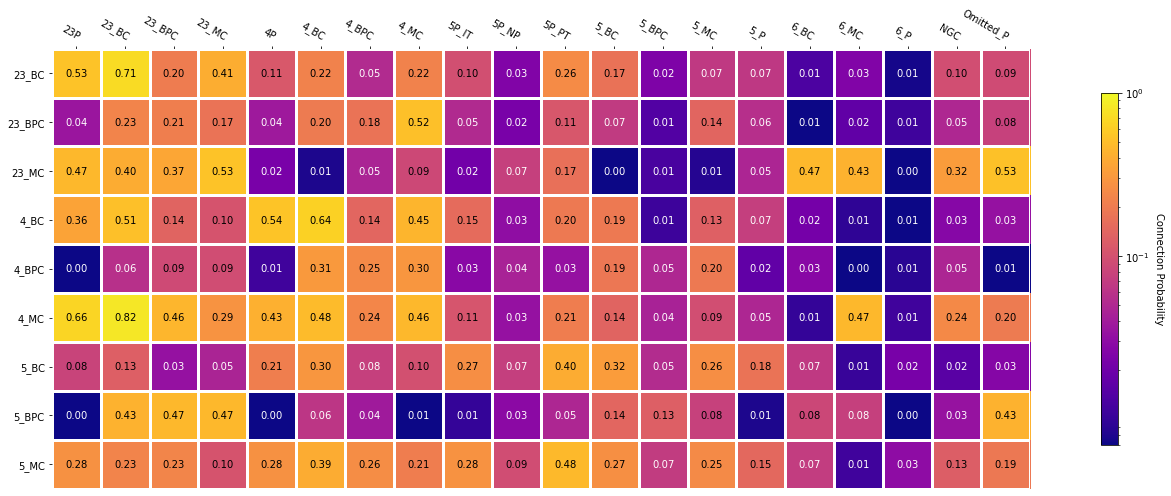

In [299]:
fig, ax = plt.subplots()
fig.set_size_inches(20,7)

im, cbar = heatmap(pmax_comb, target_list,  cell_types, ax=ax, cbar_kw={'shrink':0.8},
                   cmap="plasma", cbarlabel="Connection Probability", norm=LogNorm(vmin=0.007, vmax=1.0, clip=True))
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
fig.savefig('./plots/heatmaps/inh_pmaxheatmap-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

In [30]:
precat = []
for i in range(len(pre)):
    pppp = pd.concat(pre[i],ignore_index=True).sort_values(by='pt_position_y').reset_index(drop=True)
    precat.append(pppp)

In [31]:
pcat,sigcat,name_array = [],[],[]
for i in range(len(pre)):
    ppp,sss = [],[]
    names = []
    for j in range(len(pre[i])):
        ppp.append(precat[i].pmax.values[j])
        sss.append(precat[i].sigma_ext.values[j])
        y = np.around((precat[i].pt_position_y.values[j]*(4/1000)),1)
        names.append(cell_types[i]+', y='+str(y))
    pcat.append(ppp)
    sigcat.append(sss)
    name_array.append(names)

In [302]:
for i in tqdm(range(len(pcat))):
    fig, ax = plt.subplots()
    fig.set_size_inches(22,10)
    
    im, cbar = heatmap(pcat[i], target_list, name_array[i], ax=ax, cbar_kw={'shrink':0.8},
                       cmap="plasma", cbarlabel="Connection Probability", norm=LogNorm(vmin=0.007, vmax=1.0, clip=True))
    texts = annotate_heatmap(im, valfmt="{x:.2f}")

    fig.tight_layout()
    plt.close(fig)
    fig.savefig('./plots/{0:s}/pmaxheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))
    fig.savefig('./plots/heatmaps/{0:s}_pmaxheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))

100%|█████████████████████████████████████████████| 9/9 [00:15<00:00,  1.76s/it]


In [303]:
for i in tqdm(range(len(pcat))):
    fig, ax = plt.subplots()
    fig.set_size_inches(22,10)
    
    im, cbar = heatmap(sigcat[i], target_list, name_array[i], ax=ax, cbar_kw={'shrink':0.8},
                       cmap="plasma", cbarlabel="Sigma")
    texts = annotate_heatmap(im, valfmt="{x:.2f}")

    fig.tight_layout()
    plt.close(fig)
    fig.savefig('./plots/{0:s}/sigmaheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))
    fig.savefig('./plots/heatmaps/{0:s}_sigmaheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))

100%|█████████████████████████████████████████████| 9/9 [00:13<00:00,  1.52s/it]


In [32]:
pdepth,predepth = [],[]
for k in range(len(pcat[0][0])):
    beh,deh = [],[]
    for i in range(len(pcat)):
        bah,dah = [],[]
        for j in range(len(pcat[i])):
            bah.append(pcat[i][j][k])
            dah.append(np.around((precat[i].pt_position_y.values[j]*(4/1000)),1))
        beh.append(bah)
        deh.append(dah)
    pdepth.append(beh)
    predepth.append(deh)

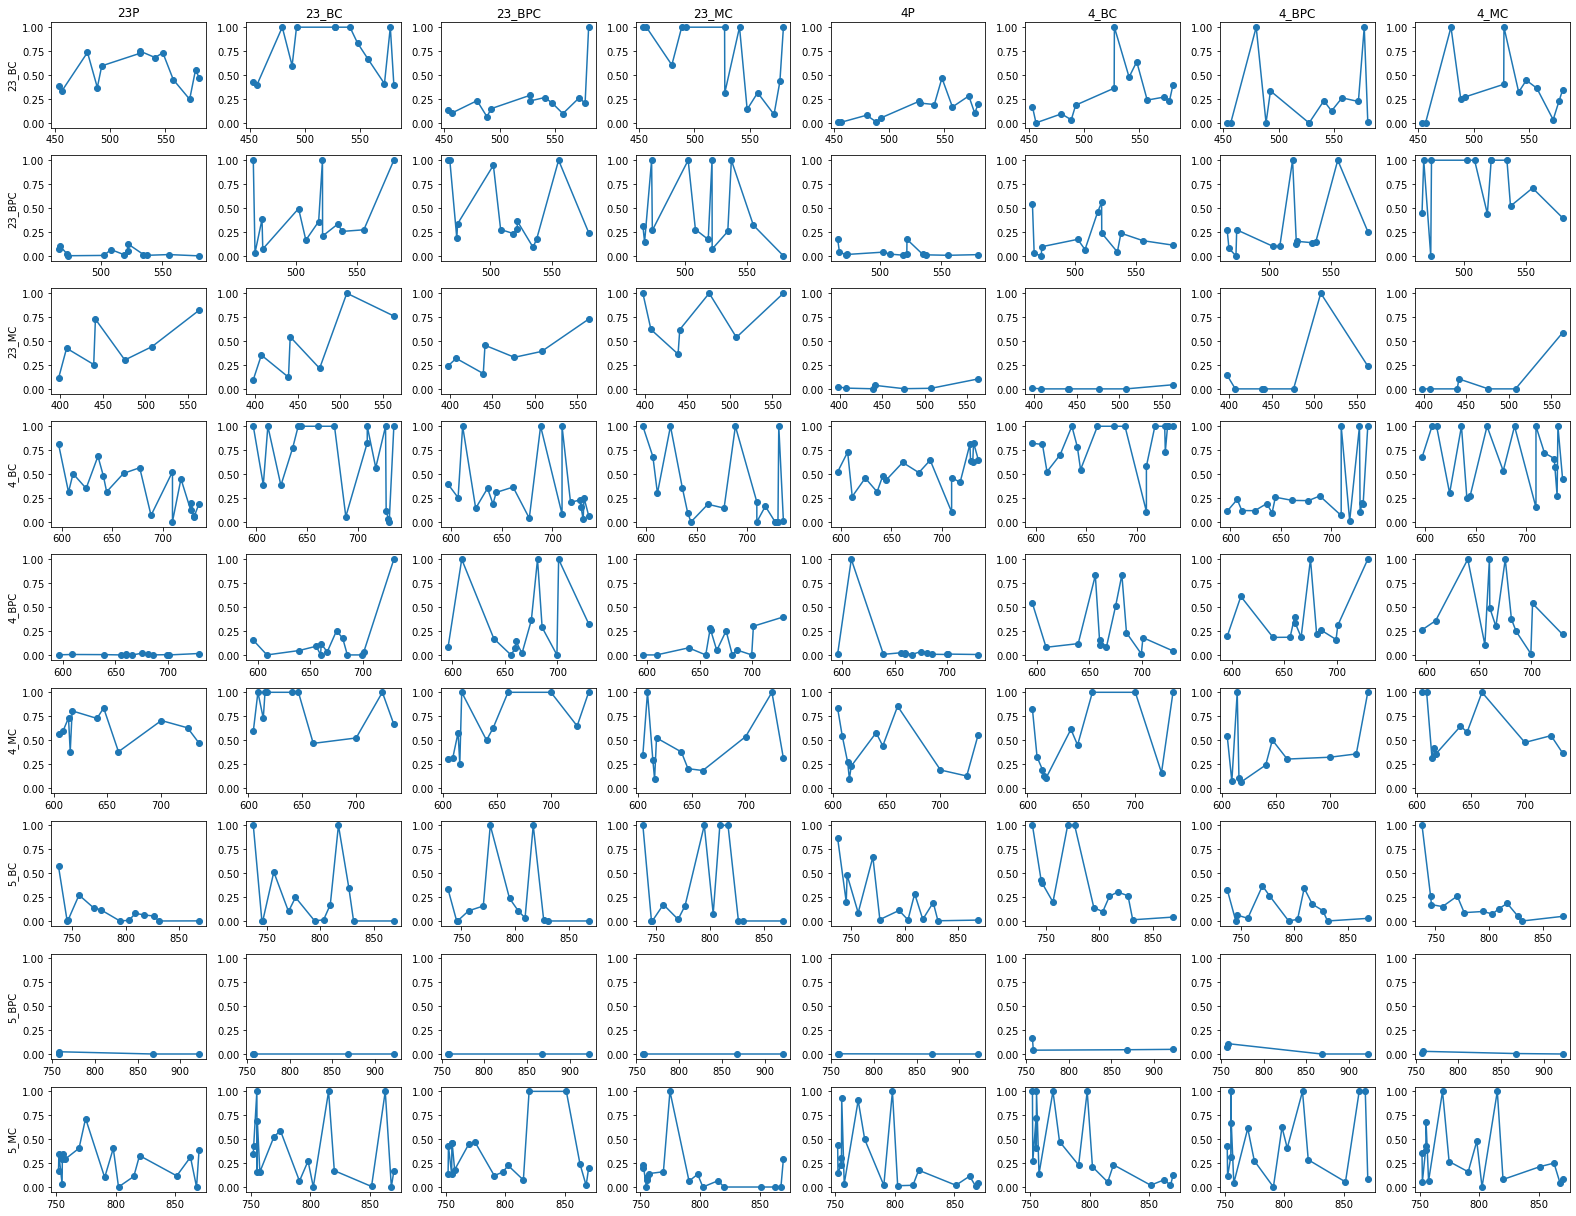

In [382]:
fig, ax = plt.subplots(int(len(pdepth[0])),8)
fig.set_size_inches(22,17)

for i in range(len(pdepth[0])):
    for j in range(8):
        ax[i,j].plot(predepth[j][i],pdepth[j][i],marker='o')
        ax[i,0].set_ylabel(cell_types[i])
        ax[i,j].set_ylim(-.05,1.05)
        ax[0,j].set_title(target_list[j])
        fig.tight_layout()
fig.savefig('./plots/heatmaps/lowlayertargets-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

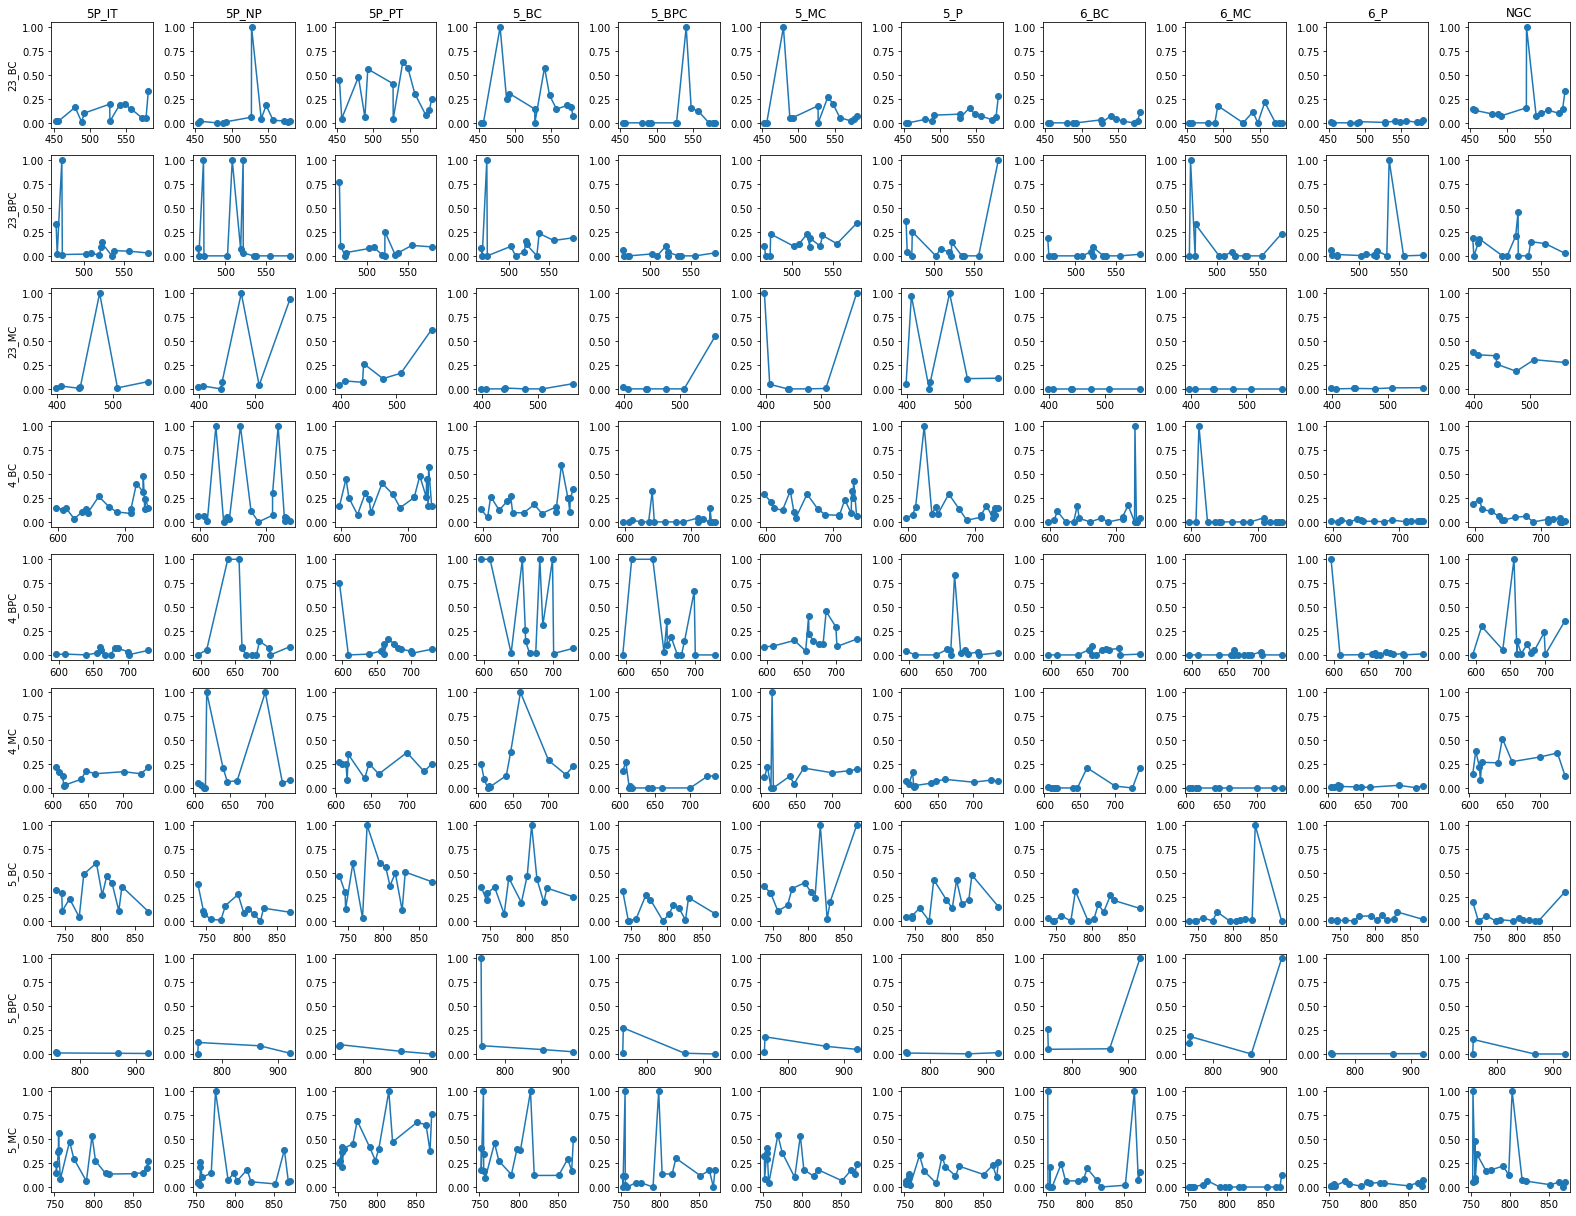

In [381]:
fig, ax = plt.subplots(int(len(pdepth[0])),11)
fig.set_size_inches(22,17)

for i in range(len(pdepth[0])):
    for j in range(11):
        ax[i,j].plot(predepth[j+8][i],pdepth[j+8][i],marker='o')
        ax[i,0].set_ylabel(cell_types[i])
        ax[i,j].set_ylim(-.05,1.05)
        ax[0,j].set_title(target_list[j+8])
        fig.tight_layout()
fig.savefig('./plots/heatmaps/highlayertargets-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

## Summary of pmax heatmap per cell:

- 23_BC (13 cells) : connectivity to 23P and 23_BC is higher mid-layer than in edge cases. increasing depth = increasing connectivity to 4P and 4_BC. sample size probably too low for consistent results in terms of connectivity to 4_BPC and 4_MC. No clear pattern for layer 5 excitatory cells. Spatial extent has a very clear increase with increasing depth, but also could be due to inconsistent connectivity for low-depth 23_BC to higher-level cells

- 23_BPC (13 cells) : very low connectivity to 23P across the board. "Preferential" connectivity to 23_BC and other 23_BPC / 4_BPC. very low connectivity to 4P across the board. sporatic/variable connectivity to 4_BC. Very high connectivity to 4_MC but very low spatial extent (ave 60 microns). low/scattered connectivity to layer 5 exc. very consistent connectivity of .1-.25 to 5_MC (ave spatial extent = 100 microns). Scattered connectivity to higher layer cells. 

- 23_MC (7 cells) : consistently high connectivity to other 23 cells (.3-.7), not much change w depth, and average spatial extent of about 100 for 23P, 80 for 23_BC & 23_BPC, and 60 for 23_MC. No connectivity whatsoever to layer 4 targets (except for one row, a 563-depth 23_MC). increasing depth = increasing connectivity to 5P_PT (ave spatial extent = 90 microns). no connectivity to layer 5 or layer 6 inhibitory (literal empty columns, which just doesn't match up with its original heatmap, so um. weird). interesting preferential connectivity (.18-.39) to NGC (ave spatial extent = 100 microns), and extremely high connectivity to the ommitted 6P cells.

- 4_BC (18 cells) : increasing depth = decreasing connectivity to 23P, moderate decrease in 23_BC, potential decrease in 23_BPC & 23_MC (low sampling), very strong connectivity to other 4_BC. Highest connectivity for 4_BPC in the middle of layer 4. connectivity to 4_MC is very inconsistent. increasing depth = increasing connectivity to 5_IT, moderate increase to 5_PT, slight increase to 5_BC. No connectivity to 5_BPC. Connectivity to 5_MC, 5_P, and 6_BC extremely inconsistent. No connectivity to 6_MC or 6_P. Increasing depth = decreasing connectivity to NGC.

- 4_BPC (13 cells) : no connectivity to 23P, increasing depth = increasing connectivity to 23_BC (low spatial extent), low connectivity to 4P, variable connectivity to 4_BC and 4_BPC (ave spatial extent = 90ish). Highest connectivity to 4_MC occurs mid-layer (ave spatial ext = 70ish). Low connectivity to 5P_IT; same for 5P_NP and PT except for the odd 100%. Variable connectivity to 5_BC and 5_BPC (ave spatial ext = 125). Low sampling for layer 6.

- 4_MC (11 cells) : no variability across depth. extremely high connectivity to 23P, 23_BC, and 23_BPC. one 4_MC at depth = 615 has very low connectivity to 23_MC and other layer 4 cells but very high connectivity to 5_MC (spatial extent = 46 microns) and the ommitted layer 5 excitatory cells (spatial extent = 32 microns). spatial extent decreases with increasing depth. generally has ave spatial extent = 70 for exc and 80 for inh, aside from a random 219 to 23_MC (from the same weird depth=615 guy)

- 5_BC (13 cells) : more patterns on a cell to cell basis than across depth. any depth-specific motifs are straight-forward (connectivity to cells in layers lower than 5 decreases as depth increases, and opposite for cells in layers higher than 5). only consistent columns are the low numbers for 6_P and selective connectivity for 5_P

- 5_BPC (4 cells) : relatively uniform connectivity profiles of .1 or lower. No connectivity whatsoever (empty columns???) until 4_BC. pmax of 1 to 6_BC and 6_MC only for the BPC that is technically in layer 6

- 5_MC (17 cells) : lower layers show typical connectivity pattern (decreases with increasing 5_MC depth). There's an interesting instance of four cells (high depth 815-860) : while they have very different connectivity for other subtypes, all have a pmax of .14 for 5P_IT. increasing depth = increasing connectivity to 5P_PT. inconsistent / random connectivity to 5_BC and NGC.

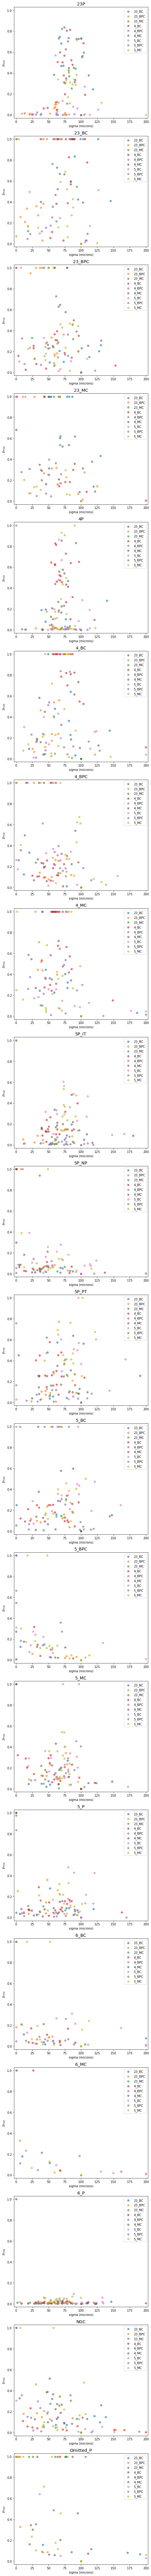

In [113]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(int(len(pmax[0])),1)
fig.set_size_inches(7,118)

for j in range(len(pmax)):
    for i in range(len(pmax[0])):
        ax[i].scatter(sigs[j][i],pmax[j][i],label=cell_types[j],alpha=.6)
        ax[i].set_xlim(-3,203)
        ax[i].set_ylim(-.03,1.03)
        ax[i].set_xlabel('sigma (microns)', fontsize=10)
        ax[i].set_ylabel(r'$p_{max}$', fontsize=10)
        ax[i].set_title(np.unique(main[0][0].cell_type)[i],fontsize=14)
        ax[i].legend()

fig.tight_layout()
fig.savefig('./plots/MLEpmaxvsig-inh-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

In [127]:
# warnings.filterwarnings('ignore')

# fig, ax = plt.subplots(int(len(pmax[0])/2),2)
# fig.set_size_inches(13,28)

# for j in range(len(pmax)):
#     for i in range(len(pmax[0])):
#         if i < 5:
#             ax[i,0].scatter(sigs[j][i],pmax[j][i],label=cell_types[j],alpha=.6)
#             ax[i,0].set_xlim(-3,203)
#             ax[i,0].set_ylim(-.03,1.03)
#             ax[i,0].set_xlabel('sigma (microns)', fontsize=14)
#             ax[i,0].set_ylabel(r'$p_{max}$', fontsize=14)
#             ax[i,0].set_title(np.unique(main[0][0].cell_type)[i])
#             ax[i,0].legend()
#         if 6 < i < 10:
#             ax[i-5,1].scatter(sigs[j][i],pmax[j][i],label=cell_types[j],alpha=.6)
#             ax[i-5,1].set_xlim(-3,203)
#             ax[i-5,1].set_ylim(-.03,1.03)
#             ax[i-5,1].set_xlabel('sigma (microns)', fontsize=14)
#             ax[i-5,1].set_ylabel(r'$p_{max}$', fontsize=14)
#             ax[i-5,1].set_title(np.unique(main[0][0].cell_type)[i])
#             ax[i-5,1].legend()

# fig.tight_layout()
# fig.savefig('./plots/MLEpmaxvsig-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

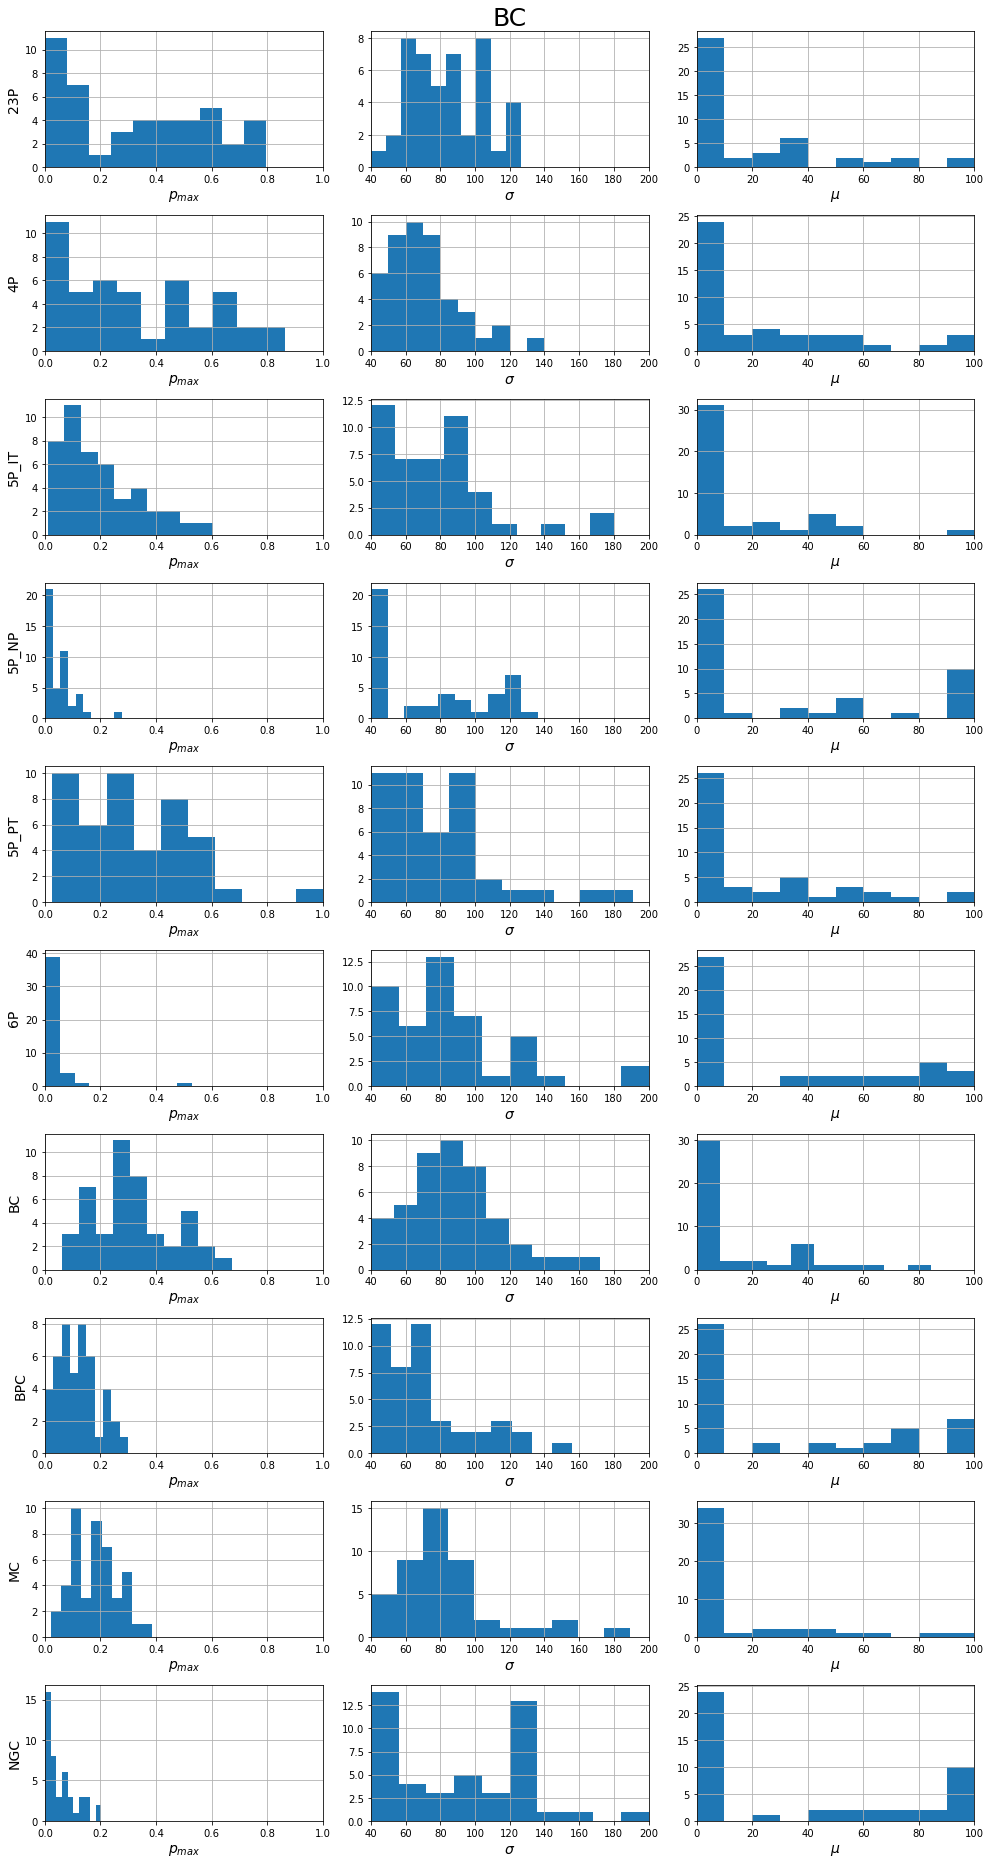

In [71]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(len(pmax),3)
fig.set_size_inches(14,26)

for i in range(len(pmax)):
    ax[i,0].hist(pmax[i])
    ax[i,0].set_xlim(0,1)
    ax[i,0].set_xlabel(r'$p_{max}$', fontsize=14)
    ax[i,0].set_ylabel(np.unique(main[0].cell_type)[i], fontsize=14)
    ax[i,0].grid()

    ax[i,1].hist(sigs[i])
    ax[i,1].set_xlim(40,200)
    ax[i,1].set_xlabel(r'$\sigma$', fontsize=14)
    ax[0,1].set_title(pre[0].cell_type[0],fontsize=25)
    ax[i,1].grid()
    
    ax[i,2].hist(moo[i])
    ax[i,2].set_xlim(0,100)
    ax[i,2].set_xlabel(r'$\mu$', fontsize=14)
    ax[i,2].grid()

fig.tight_layout()
fig.savefig('./plots/{0:s}/MLE-{1:s}-{2:s}bin.pdf'.format(str(pre[0].cell_type[0]),str(up),str(r_interval)))
#fig.savefig('./plots/{0:s}/MLE-{1:s}-{2:s}bin-{3:s}thresh.pdf'.format(str(pre[0].cell_type[0]),str(up),str(r_interval),str(threshold)))

In [54]:
pmodel = []
for i in range(len(syn_types)):
    pcell = []
    for j in range(len(syn_types[i])):
        p = connect_stats.probfunct(results[i][j].x,syn_types[i][j])
        pcell.append(p)
    pmodel.append(pcell)

In [48]:
# d_main,d_syn,d_nonsyn = [],[],[]
# d_main_types,d_syn_types,d_nonsyn_types = [],[],[]
# d_f_type,d_s_type = [],[]
# for i in tqdm(range(len(pre))):
#     dm,ds,dn,dmt,dst,dnt,ddf,dds = make_tables.depth_divider(depths,main[i],syn[i],nonsyn[i],r_interval,up)
#     d_main.append(dm)
#     d_syn.append(ds)
#     d_nonsyn.append(dn)
#     d_main_types.append(dmt)
#     d_syn_types.append(dst)
#     d_nonsyn_types.append(dnt)
#     d_f_type.append(ddf)
#     d_s_type.append(dds)


# pmax = []
# for i in tqdm(range(len(pre))):
#     d_pmax = []
#     for j in range(len(d_f_type[i])):
#         ddpp = []
#         for k in range(len(d_f_type[i][j])):
#             pm = connect_stats.pmax_type(d_s_type[i][j][k],d_f_type[i][j][k])
#             ddpp.append(pm)
#         d_pmax.append(ddpp)
#     pmax.append(d_pmax)
    
    
# mu = 0
# results = []
# for i in tqdm(range(len(pre))):
#     presyntype = []
#     for j in range(len(d_syn_types[i])):
#         rcelldepth = []
#         for k in range(len(d_syn_types[i][j])):
#             rcell = []
#             if pre[i][j].cell_type.values[0] == any(['BC','BPC','MC']):
#                 sigs = [95,95,95,95,95,95,125,125,125,95]
#             else:
#                 sigs = [125,125,125,125,125,125,95,95,95,125]
#             for l in range(len(d_syn_types[i][j][k])):
#                 init_guess = [pmax[i][j][k][l],sigs[l],mu]
#                 r = minimize(fun=connect_stats.log_likelihood,x0=init_guess,bounds=[(0,1.),(0,200),(0,100)],
#                              method='nelder-mead',options={'maxfev':1000},args=(d_syn_types[i][j][k][l],d_nonsyn_types[i][j][k][l]))
#                 rcell.append(r)
#             rcelldepth.append(rcell)
#         presyntype.append(rcelldepth)    
#     results.append(presyntype)
    
    
# pmax,sigs,moo = [],[],[]
# for i in range(len(results)):
#     prep,pres,prem = [],[],[]
#     for j in range(len(results[i])):
#         dp,ds,dm = [],[],[]
#         for l in range(len(results[i][j][0])):
#             typep,types,typem = [],[],[]
#             for k in range(len(results[i][j])):
#                 typep.append(results[i][j][k][l].x[0])
#                 types.append(results[i][j][k][l].x[1])
#                 typem.append(results[i][j][k][l].x[2])
#             dp.append(typep)
#             ds.append(types)
#             dm.append(typem)
#         prep.append(dp)
#         pres.append(ds)
#         prem.append(dm)
#     pmax.append(prep)
#     sigs.append(pres)
#     moo.append(prem)